# Experimental analysis of minimum difference height levels

The idea is that, for every MCS track point, there will be a height level that has the minimum difference from the movement velocity of the MCS. This is just a minimum in the squared difference of u and vel_x..., calculated in the remakefile loaded below. The level is saved for each point - here, I've got code to turn this into a figure. I've borrowed code from `np.histogramdd` to get indices of each of the lon/lat points to use to store the level data. Then I make a 3D array (hist.max(), nlon, nlat) to store the level data, and match it up using the indices. Finally plot mean/stdon a map.

I am calling the resulting level a "steering level".

Data was produced for 2019 only at the moment.

After initial analysis, it seemed like restricting the data more could help. So the end analysis here limits model levels to >= 77 and < 137 (bottom level - overrepresented).

* 20/5/22: Initial work.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import xarray as xr

from remake import load_remake
%matplotlib notebook

In [2]:
tep = load_remake('../../remakefiles/track_era5_propagation_corr.py')

# There are 365 for 2019 of these saved on JASMIN currently.
linked_data_paths = [t.outputs['track_era5_linked_data'] for t in tep.TrackERA5LinkData.tasks]

ds = xr.open_mfdataset(linked_data_paths, concat_dim='index', combine='nested')
ds['index'] = np.arange(len(ds['index']))

ds

<xarray.Dataset>
Dimensions:             (index: 541495, level: 4)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 541491 541492 541493 541494
  * level               (level) int32 77 97 117 137
Data variables:
    point_time          (index) datetime64[ns] dask.array<chunksize=(1169,), meta=np.ndarray>
    meanlon             (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    meanlat             (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    track_point_era5_u  (level, index) float32 dask.array<chunksize=(4, 1169), meta=np.ndarray>
    track_point_era5_v  (level, index) float32 dask.array<chunksize=(4, 1169), meta=np.ndarray>
    track_point_vel_x   (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    track_point_vel_y   (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    min_diff_level      (index) int32 dask.array<chunksize=(1169,), meta=np.ndarray>
    min_sq_diff         (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>

In [3]:
lonlat = np.vstack([ds.meanlon.values, ds.meanlat.values]).T

lonlat.shape

(541495, 2)

In [4]:
edges = (np.arange(-180, 184, 4), np.arange(-60, 64, 4))
nbins = np.array([len(e) - 1 for e in edges])

In [5]:
# Code below borrows heavily from np.histogramdd

# Calc. the two indexes (lon, lat) by digitizing each value based on bins.
# The -1 puts the indices in the correct place for 2D array access.
idx = tuple(
    np.digitize(lonlat[:, i], edges[i]) - 1
    for i in range(2)
)

In [6]:
# Flatten the two indices into one (for a flattened array)
flat_idx = np.ravel_multi_index(idx, nbins)

# Calc the histogram values.
hist = np.bincount(flat_idx, minlength=nbins.prod())

# Reshape back to 2D.
hist = hist.reshape(nbins)
hist

array([[ 59,  49,  36, ...,  43,  18,  19],
       [ 58,  63,  71, ...,  45,  12,   7],
       [ 41,  53,  63, ...,  58,  37,   9],
       ...,
       [ 40,  73, 119, ...,  62,  18,  14],
       [ 74,  94, 105, ...,  47,  40,  12],
       [ 74,  55,  83, ...,  55,  20,  13]])

<IPython.core.display.Javascript object>


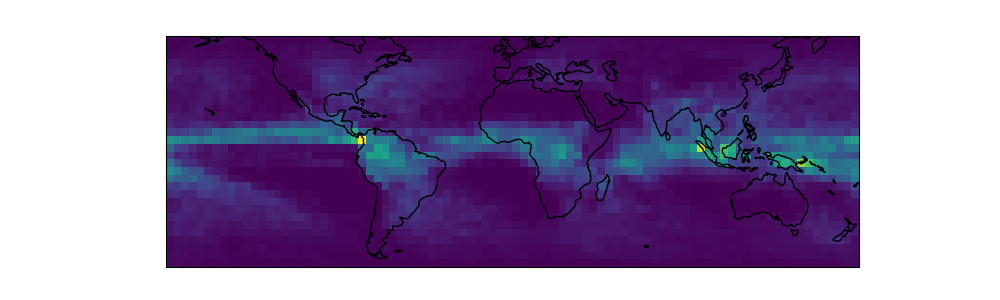

In [7]:
# Sanity check. Plot MCS hist.
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 3)
ax.imshow(hist.T, origin='lower', extent=(-180, 180, -60, 60))
ax.coastlines();

In [8]:
hist.max()

2247

In [9]:
hist.shape

(90, 30)

In [10]:
# Construct a 3D np.nan array which will hold the values of mindiff height levels.
mindiff_height_level = np.full((2247, 90, 30), np.nan)

In [11]:
# Find unique flat/2D indices.
uniq_flat_idx = np.unique(flat_idx)
uniq_idx = np.array(np.unravel_index(uniq_flat_idx, nbins))

In [12]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = ds.min_diff_level.values

In [13]:
# Pull out the min_diff level data for each unique flat index.
for ufi, ui in zip(uniq_flat_idx, uniq_idx.T):
    # Use data from hist to get correct number of levels to store.
    # Use ui[0], ui[1] to index into lon/lat coords.
    # Mask out values using flat_idx == ufi for each unique index.
    mindiff_height_level[:hist[ui[0], ui[1]], ui[0], ui[1]] = min_diff_level[flat_idx == ufi]

In [14]:
np.nanmean(mindiff_height_level)

84.34900414592933

<IPython.core.display.Javascript object>


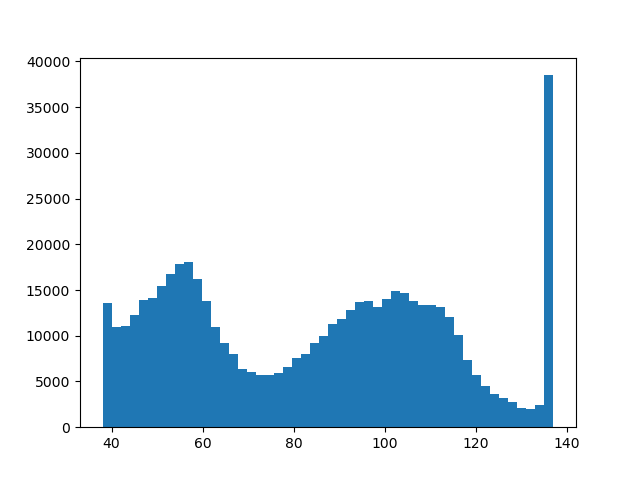

In [15]:
plt.figure()
plt.hist(min_diff_level, bins=50);

Large spike in values at 137 (surf) means that results probably not best analysed using mean, as this will drag down most values. Try using median as well.

Apart from that, clearly bimodal, with modes at level 57, level 103.

In [16]:
def plot_min_diff_levels(name, func, mindiff_height_level, reduced_levels=False):
    data = func(mindiff_height_level, axis=0).T
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches(10, 3)
    if name == 'std':
        levels = [0, 10, 20, 30, 40, 50]
    elif name in ['median', 'mean']:
        levels = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 137]
        if reduced_levels:
            levels = levels[3:]
    else:
        levels = np.linspace(0, data.max(), 20)    
    norm = colors.BoundaryNorm(levels, ncolors=256)
    im = ax.imshow(data, origin='lower', 
                   norm=norm, cmap='Spectral',
                   extent=(-180, 180, -60, 60))
    ax.coastlines()
    cbar = plt.colorbar(im)
    if name in ['mean', 'median']:
        # Taken roughly from here: https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height?preview=/158636068/226495690/levels_137.png
        # N.B. these are ocean/zero orog. values.
        level_press_map = {
            40: 28,
            50: 56,
            60: 100,
            70: 150,
            80: 260,
            90: 420,
            100: 600,
            110: 800,
            # Hard to read 120/130 off image.
            137: 1000,
        }
        def fmt_label(k, v):
            if v:
                return f'{k} - {v} hPa'
            else:
                return k
        labels = [fmt_label(k, level_press_map.get(k, None)) for k in levels]
        cbar.ax.set_yticks(levels, labels=labels)
    ax.set_title(f'{name} level of minimum difference')
    plt.show()

/tmp/ipykernel_29259/4210386693.py:2: RuntimeWarning: Mean of empty slice
  data = func(mindiff_height_level, axis=0).T


<IPython.core.display.Javascript object>


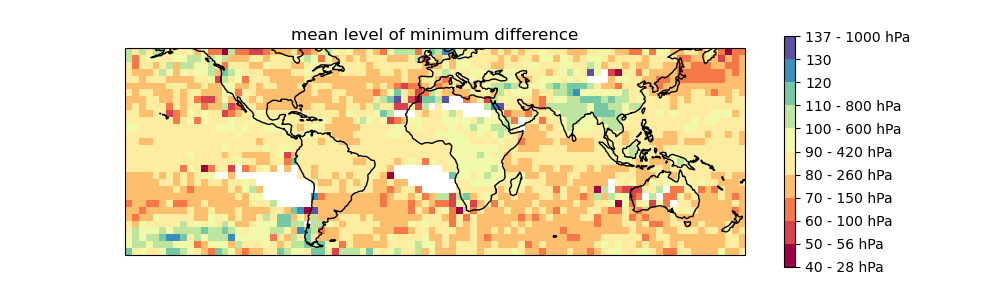

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


<IPython.core.display.Javascript object>


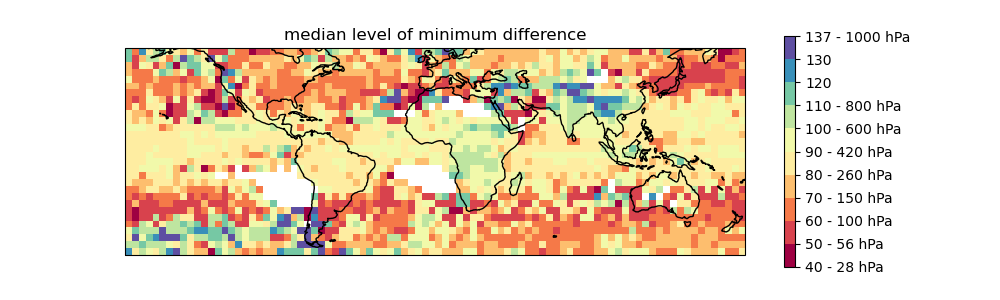

In [17]:
plot_min_diff_levels('mean', np.nanmean, mindiff_height_level)
plot_min_diff_levels('median', np.nanmedian, mindiff_height_level)

The mean figure above gives a sense of the "steering level" (used loosely) of MCSs accross the globe. Things to note:
* Over the eq. ocean, steering level is mainly 260 - 420 hPa. Amazon steering level is similar.
* Over Africa, steering level is generally 420 - 600 hPa.
* Over India/China, steering level is lower at 600 - 800 hPa.
* Over US, steering level is generally higher at 150 - 260 hPa.

The median figure is quite close to mean in tropics, biggest differences are in the subtropics. Suggests a large number of the spike at model 137 in this region. Steering level over Africa/Asia reduces, also over ocean.

Also worth remembering that over land, a given model level will be higher than over ocean. Perhaps explains low model levels over Himalayas.

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<IPython.core.display.Javascript object>


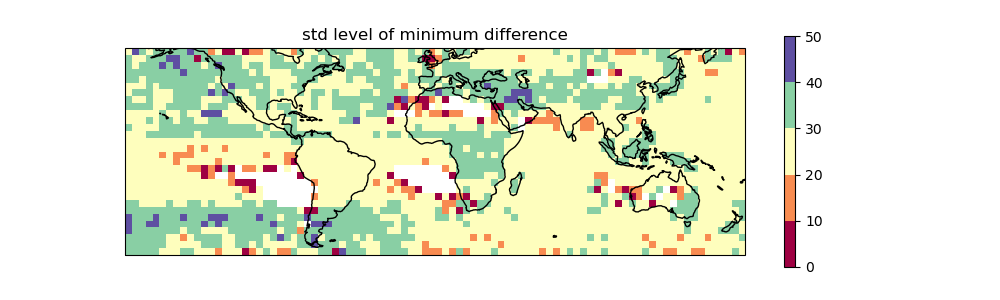

In [18]:
plot_min_diff_levels('std', np.nanstd, mindiff_height_level)

Standard deviation is generally 20-30 model level (eq. ocean), 20-40 levels (land/non-eq ocean). Low values probably just indicate not enough data (could mask out low numbers of MCSs...). 

Interesting line running just N of eq. through Pacific. Don't think this is an artefact. Not obvious in mean. 

<IPython.core.display.Javascript object>


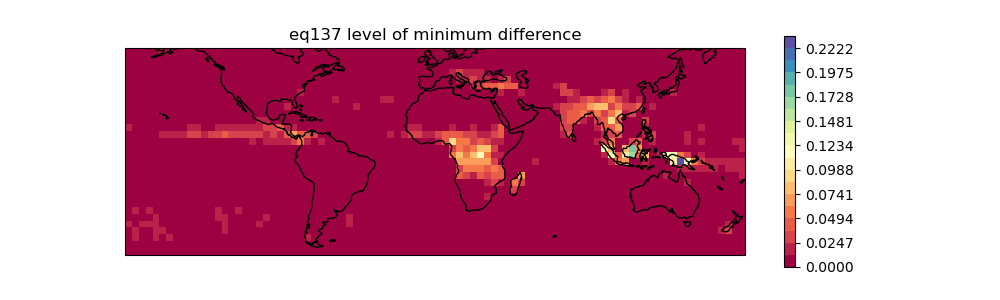

In [19]:
def eq137(mindiff_height_level, axis):
    return np.nanmean(mindiff_height_level == 137, axis=axis)

plot_min_diff_levels('eq137', eq137, mindiff_height_level)

In [20]:
np.nanmean(mindiff_height_level == 137, axis=0).max()

0.2345349354695149

Not what I was expecting. Max values over central Africa, and Asia. These are the regions where the median is lower than the mean (i.e. model level is higher).

## Regional analysis

Pick out 6 regions based on where MCS activity is, where looks interesting for steering level.

<IPython.core.display.Javascript object>


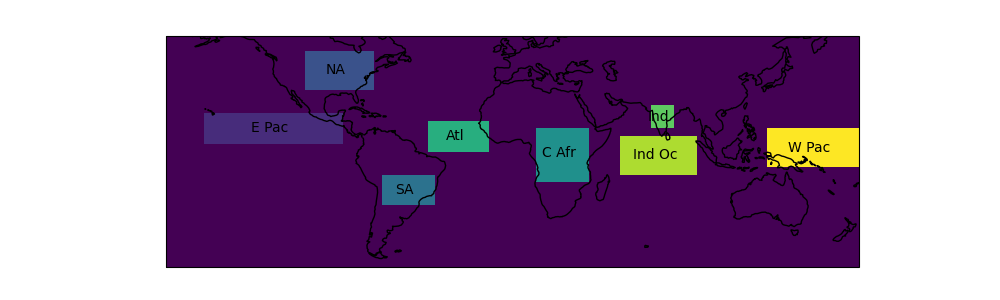

In [21]:
from itertools import product
lons, lats = edges
def get_reg(minx, maxx, miny, maxy):
    idx = np.array(list(product(np.where((lons >= minx) & (lons <= maxx))[0], np.where((lats >= miny) & (lats <= maxy))[0]))).T
    return tuple([idx[0], idx[1]])

reg = np.zeros_like(hist)

rvals = [
    ('E Pac', (-160, -92, 4, 16)),
    ('NA', (-108, -76, 32, 48)),
    ('SA', (-68, -44, -28, -16)),
    ('C Afr', (12, 36, -16, 10)),
    ('Atl', (-44, -16, 0, 12)),
    ('Ind', (72, 80, 12, 20)),
    ('Ind Oc', (56, 92, -12, 4)),
    ('W Pac', (132, 176, -8, 8)),
]
for i, rval in enumerate(rvals):
    reg[get_reg(*rval[1])] = i + 1
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 3)
for i, rval in enumerate(rvals):
    meanx, meany = np.mean(rval[1][:2]), np.mean(rval[1][2:])
    ax.annotate(xy=(meanx, meany), text=rval[0], ha='center')
ax.imshow(reg.T, origin='lower', extent=(-180, 180, -60, 60))
ax.coastlines();

<IPython.core.display.Javascript object>


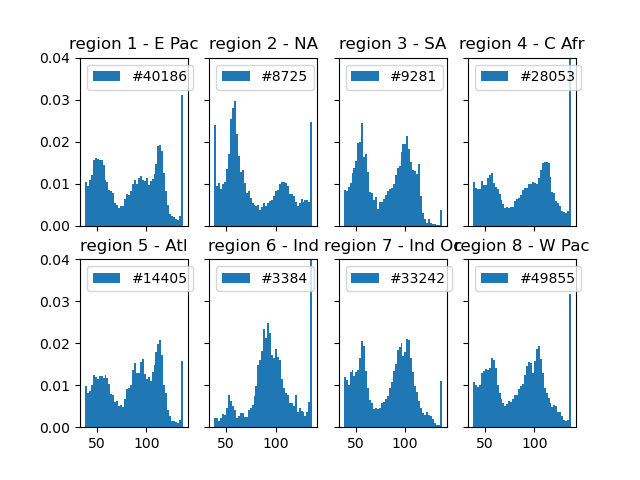

In [22]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for i, (rval, ax) in enumerate(zip(rvals, axes.flatten())):
    d = mindiff_height_level[:, reg == i + 1]
    ax.hist(d[~np.isnan(d)], bins=50, density=True, label=f'#{(~np.isnan(d)).sum()}')
    ax.set_title(f'region {i + 1} - {rval[0]}')
    ax.set_ylim((0, 0.04))
    ax.legend(loc='upper left')


N.B. regions 4 (C. Africa) and 6 (India) have values for 137 that are off the scale (0.1). Not shown for comparison/ease of viewing. 

All show a bimodal structure, with peaks at approx model level 100 and 50 (600 hPa, 56 hPa respectively). I do not think I am interested in the peak at 56 hPa - perhaps limit to the lower local minimum at 71? Some shows signs of being trimodal (particularly over ocean?). That said, there are some differences in the peak at 50. E.g., very high for NA, very low for Ind. Why? Presumably related to jet being important over NA?

For the peak near level 100, E Pac and Atl show lowest peak at 115 (roughly 850 hPa). Ind highest at 94 (500 hPa). N.B. this adds a lot of extra info to maps above, because in those maps India has the lowest mean/median model levels over a large area. This is clearly because the second peak near 50 is so low for India.

## Redo analysis but only for levels greater than 77

Following regional analysis, and local minima in each of the regions, level 77 chosen to highlight lower peak near level 100.

In [23]:
level_mask = min_diff_level >= 77

In [24]:
# Find unique flat/2D indices.
uniq_flat_idx = np.unique(flat_idx[level_mask])
uniq_idx = np.array(np.unravel_index(uniq_flat_idx, nbins))

In [25]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = min_diff_level[level_mask]

In [26]:
# Construct a 3D np.nan array which will hold the values of mindiff height levels.
mindiff_height_level = np.full((2247, 90, 30), np.nan)

In [27]:
# Pull out the min_diff level data for each unique flat index.
for ufi, ui in zip(uniq_flat_idx, uniq_idx.T):
    # Use data from hist to get correct number of levels to store.
    # Use ui[0], ui[1] to index into lon/lat coords.
    # Mask out values using flat_idx == ufi for each unique index.
    mask = flat_idx[level_mask] == ufi
    mindiff_height_level[:mask.sum(), ui[0], ui[1]] = min_diff_level[mask]

/tmp/ipykernel_29259/4210386693.py:2: RuntimeWarning: Mean of empty slice
  data = func(mindiff_height_level, axis=0).T


<IPython.core.display.Javascript object>


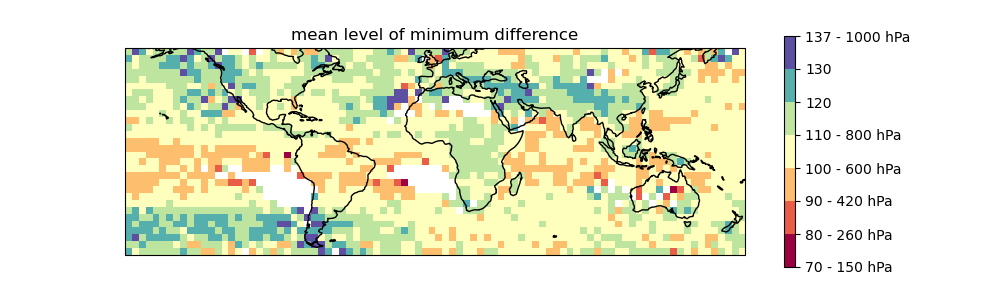

<IPython.core.display.Javascript object>


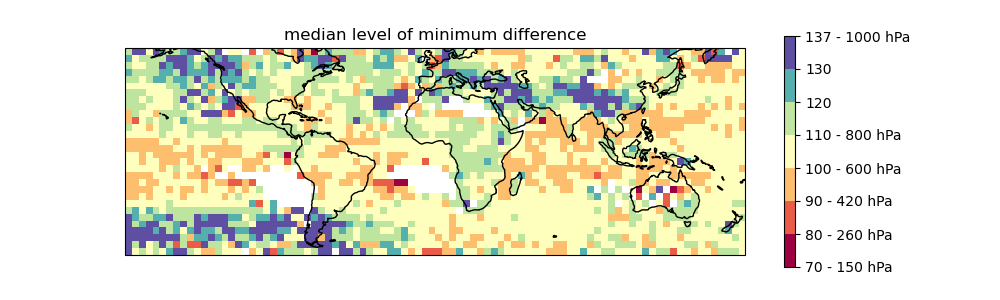

In [28]:
plot_min_diff_levels('mean', np.nanmean, mindiff_height_level, True)
plot_min_diff_levels('median', np.nanmedian, mindiff_height_level, True)

Results look a bit more believable as a steering level than above. I also think it's justifiable to limit the analysis to 150 hPa. That seems fine to me.

Think something strange is still going on over India. Results are heavily skewed by large number of 137s (see regional hist below). Same possibly true of C Afr, NA. Perhaps I should filter these out?

* steering level between 420 - 800 hPa over E Pac
* Ditto SA/Amazon, Indian Ocean
* W Pac 600 - 800 hPa
* C Afr - 800 - 860 hPa
* Signal of TP N of India.

<IPython.core.display.Javascript object>


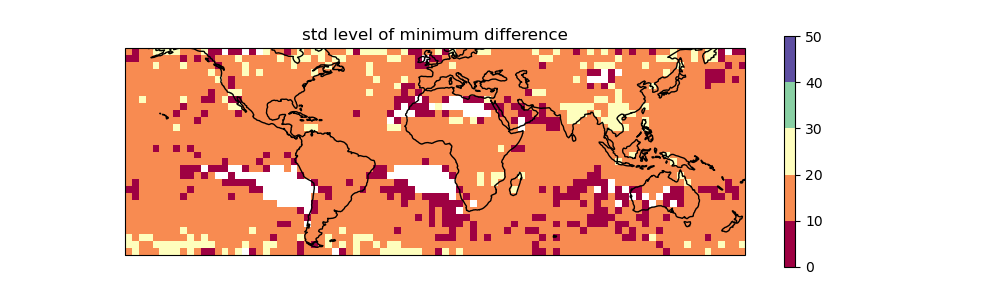

In [29]:
plot_min_diff_levels('std', np.nanstd, mindiff_height_level)

<IPython.core.display.Javascript object>


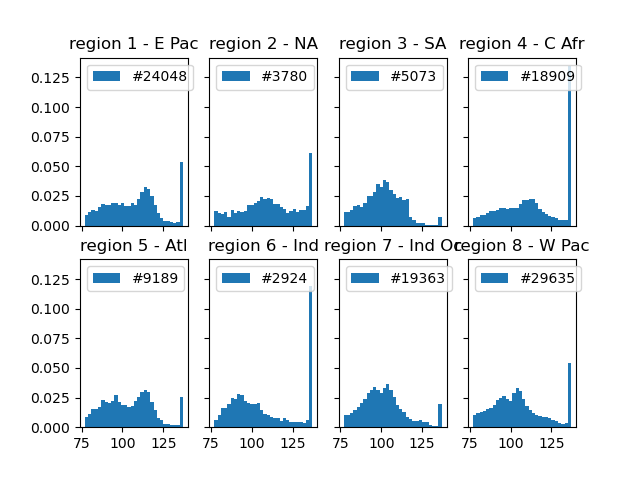

In [30]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for i, (rval, ax) in enumerate(zip(rvals, axes.flatten())):
    d = mindiff_height_level[:, reg == i + 1]
    ax.hist(d[~np.isnan(d)], bins=30, density=True, label=f'#{(~np.isnan(d)).sum()}')
    ax.set_title(f'region {i + 1} - {rval[0]}')
    # ax.set_ylim((0, 0.06))
    ax.legend(loc='upper left')


## Redo analysis but only for levels greater than 77 and less than 137

Following regional analysis, and local minima in each of the regions, level 77 chosen to highlight lower peak near level 100.

In [31]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = ds.min_diff_level.values
level_mask = (min_diff_level >= 77) & (min_diff_level < 137)

In [32]:
# Find unique flat/2D indices.
uniq_flat_idx = np.unique(flat_idx[level_mask])
uniq_idx = np.array(np.unravel_index(uniq_flat_idx, nbins))

In [33]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = min_diff_level[level_mask]

In [34]:
# Construct a 3D np.nan array which will hold the values of mindiff height levels.
mindiff_height_level = np.full((2247, 90, 30), np.nan)

In [35]:
# Pull out the min_diff level data for each unique flat index.
for ufi, ui in zip(uniq_flat_idx, uniq_idx.T):
    # Use data from hist to get correct number of levels to store.
    # Use ui[0], ui[1] to index into lon/lat coords.
    # Mask out values using flat_idx == ufi for each unique index.
    mask = flat_idx[level_mask] == ufi
    mindiff_height_level[:mask.sum(), ui[0], ui[1]] = min_diff_level[mask]

/tmp/ipykernel_29259/4210386693.py:2: RuntimeWarning: Mean of empty slice
  data = func(mindiff_height_level, axis=0).T


<IPython.core.display.Javascript object>


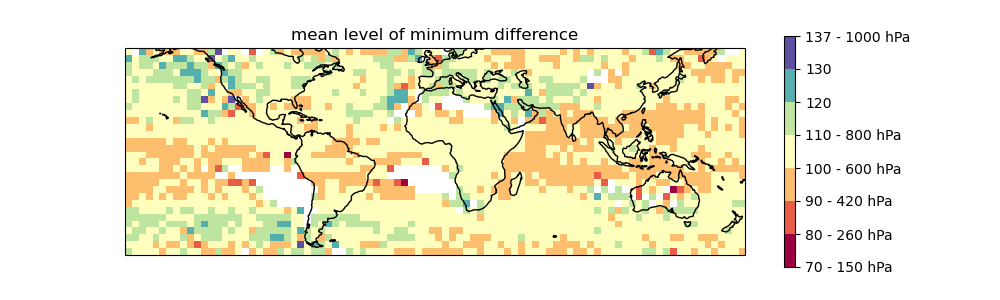

<IPython.core.display.Javascript object>


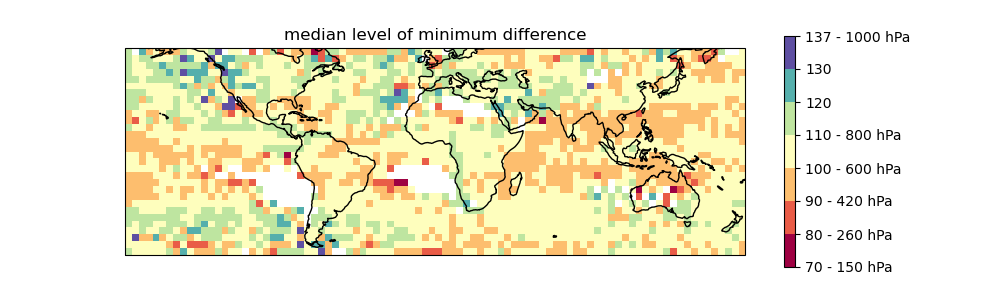

In [36]:
plot_min_diff_levels('mean', np.nanmean, mindiff_height_level, True)
plot_min_diff_levels('median', np.nanmedian, mindiff_height_level, True)

Less of a contrast with 137 not included - eq. generally between 420 - 800 hPa. This seems quite believable as well. Generally higher over Oc, particularly Indian Oc/W Pac. Now higher over Indida as well. Better aggreement by eye between mean/median.

<IPython.core.display.Javascript object>


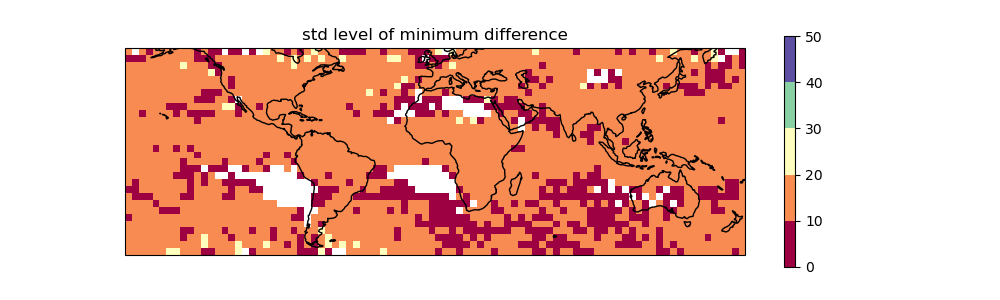

In [37]:
plot_min_diff_levels('std', np.nanstd, mindiff_height_level)

<IPython.core.display.Javascript object>


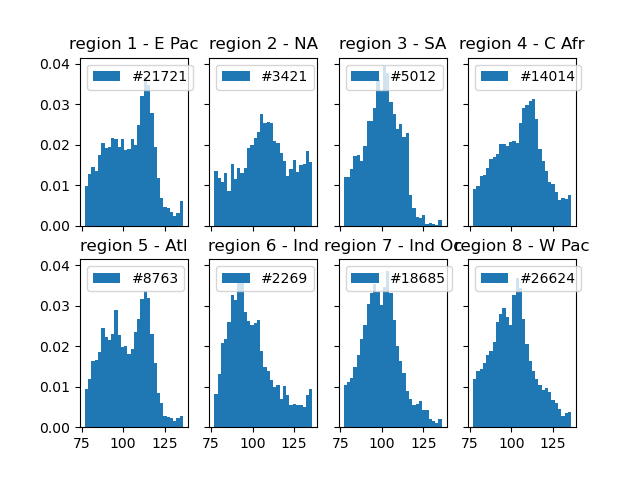

In [38]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for i, (rval, ax) in enumerate(zip(rvals, axes.flatten())):
    d = mindiff_height_level[:, reg == i + 1]
    ax.hist(d[~np.isnan(d)], bins=30, density=True, label=f'#{(~np.isnan(d)).sum()}')
    ax.set_title(f'region {i + 1} - {rval[0]}')
    # ax.set_ylim((0, 0.06))
    ax.legend(loc='upper left')


Broadly matches maps now.